In [20]:
#!pip install praw transformers torch
import praw
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

In [37]:
def fetch_reddit_posts(subreddit, query, limit=100, days=120):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    current_time = datetime.utcnow()
    time_filter = current_time - timedelta(days=days)
    for post in subreddit.search(query, limit=limit):
        post_date = datetime.utcfromtimestamp(post.created_utc)
        if post_date > time_filter:
            posts.append([post_date, post.title, post.selftext])
    print(pd.DataFrame(posts, columns=["Date", "Title", "Body"]))
    return pd.DataFrame(posts, columns=["Date", "Title", "Body"])

In [38]:
fetch_reddit_posts('all', 'ChatGPT', 100)

                  Date                                              Title  \
0  2024-05-14 07:36:18                           The new ChatGPT is "Her"   
1  2024-03-21 18:00:04         You can create realistic images in ChatGPT   
2  2024-04-05 17:57:45  Kids think ChatGPT is going to save them…. Tur...   
3  2024-05-13 20:11:45  This is how ChatGPT reacts when seeing a good ...   
4  2024-03-07 21:55:30                    ChatGPT is a double-edged sword   
5  2024-03-13 23:02:01   Obvious ChatGPT prompt reply in published paper    
6  2024-04-13 00:08:08  I Asked ChatGPT to generate memes it thought w...   
7  2024-02-01 17:14:57                              ChatGPT saved me $250   
8  2024-05-20 15:11:24  Analysis of ChatGPT answers to 517 programming...   
9  2024-03-06 08:04:05   I asked ChatGPT which job can he never take over   
10 2024-02-21 11:13:35  ChatGPT has meltdown and starts sending alarmi...   
11 2024-04-09 15:47:56  Apparently using the word “delve” is a sign of...   

,Date,Title,Body
0,2024-05-14 07:36:18,"The new ChatGPT is ""Her""",
1,2024-03-21 18:00:04,You can create realistic images in ChatGPT,using https://chat.openai.com/g/g-q9wdIq7OQ-ph...
2,2024-04-05 17:57:45,Kids think ChatGPT is going to save them…. Tur...,Love what just happened. My students turned in...
3,2024-05-13 20:11:45,This is how ChatGPT reacts when seeing a good ...,
4,2024-03-07 21:55:30,ChatGPT is a double-edged sword,TLDR: tell chatGPT to explain the solution rat...
5,2024-03-13 23:02:01,Obvious ChatGPT prompt reply in published paper,Look it up: https://doi.org/10.1016/j.surfin.2...
6,2024-04-13 00:08:08,I Asked ChatGPT to generate memes it thought w...,
7,2024-02-01 17:14:57,ChatGPT saved me $250,TLDR: ChatGPT helped me jump start my hybrid t...
8,2024-05-20 15:11:24,Analysis of ChatGPT answers to 517 programming...,
9,2024-03-06 08:04:05,I asked ChatGPT which job can he never take over,


In [34]:
df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

In [35]:
def clean_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text.lower()

df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
df_copilot['Body'] = df_copilot['Body'].apply(clean_text)

In [36]:
df_chatgpt

,Date,Title,Body
0,2024-05-14 07:36:18,"The new ChatGPT is ""Her""",
1,2024-03-21 18:00:04,You can create realistic images in ChatGPT,using
2,2024-04-05 17:57:45,Kids think ChatGPT is going to save them…. Tur...,love what just happened my students turned in ...
3,2024-05-13 20:11:45,This is how ChatGPT reacts when seeing a good ...,
4,2024-03-07 21:55:30,ChatGPT is a double-edged sword,tldr tell chatgpt to explain the solution rath...
5,2024-03-13 23:02:01,Obvious ChatGPT prompt reply in published paper,look it up crazy how it good through peer review
6,2024-04-13 00:08:08,I Asked ChatGPT to generate memes it thought w...,
7,2024-02-01 17:14:57,ChatGPT saved me $250,tldr chatgpt helped me jump start my hybrid to...
8,2024-05-20 15:11:24,Analysis of ChatGPT answers to 517 programming...,
9,2024-03-06 08:04:05,I asked ChatGPT which job can he never take over,


In [16]:
# Load sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=510):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis
df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

Token indices sequence length is longer than the specified maximum sequence length for this model (885 > 512). Running this sequence through the model will result in indexing errors


In [17]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].value_counts(normalize=True))

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].value_counts(normalize=True))

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].value_counts(normalize=True))


ChatGPT Sentiment Statistics:
Sentiment
POSITIVE    0.84
NEGATIVE    0.16
Name: proportion, dtype: float64
Gemini AI Sentiment Statistics:
Sentiment
POSITIVE    0.75
NEGATIVE    0.25
Name: proportion, dtype: float64
Copilot AI Sentiment Statistics:
Sentiment
POSITIVE    0.75
NEGATIVE    0.25
Name: proportion, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


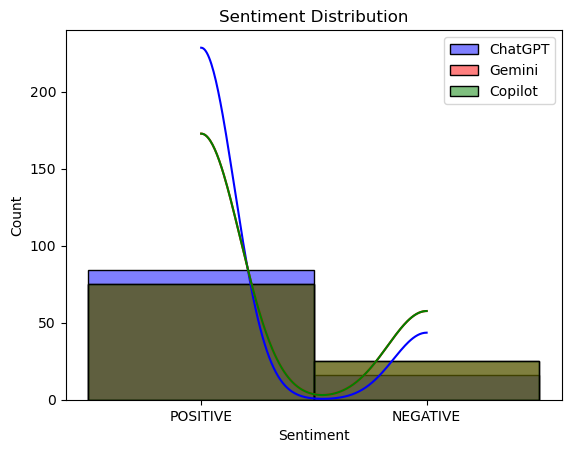

In [18]:
sns.histplot(df_chatgpt['Sentiment'], kde=True, label='ChatGPT', color='blue')
sns.histplot(df_gemini['Sentiment'], kde=True, label='Gemini', color='red')
sns.histplot(df_copilot['Sentiment'], kde=True, label='Copilot', color='green')
plt.legend()
plt.title('Sentiment Distribution')
plt.show()
